In [448]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random


from termcolor import colored

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Model
# --------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [449]:
def metricas(validacion, prediccion, churm):
    
    print("Exactitud: ", metrics.accuracy_score(validacion, prediccion))
    print("Kappa: ", metrics.cohen_kappa_score(validacion, prediccion))
    
    print(colored('Predicciones de los registros mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[1], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[1], average='macro'))
    
    VP = np.sum(churm[1:2,1:2])
    FN = np.sum(churm[1,0:1])
    specificity = VP/(VP+FN)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[1], average='macro'))
    
    
    print(colored('Predicciones de los registros no mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[0], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[0], average='macro'))
    
    VP = np.sum(churm[0:1,0:1])
    FN = np.sum(churm[0,1:2])
    specificity = VP/(VP+FN)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[0], average='macro'))

In [450]:
def matriz_confusion(validacion, prediccion, cmap):
    print(colored('Matriz de confusión', attrs=['bold']))
    churm = metrics.confusion_matrix(validacion, prediccion)
    plt.imshow(churm, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not_mine','Mine'])
    plt.yticks(tick_marks, ['Not_mine','Mine'])
    return churm

# Load Data

In [451]:
dataA = pd.read_csv('./data_identificada.csv').drop(['index','Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataA.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type,Cryptocurrency
0,400,TCP,0.0,0.0,9.04175,4287.992,65.519,0.0,6750,360512,...,53.0,80.0,1.0,1.0,5.5,32.0,33.0,873.0,not_mine,Does not have


# Preprocesamiento

### Imputación de valores ausentes

In [452]:
punter = pd.concat([dataA['second_sp'],dataA['second_dp'],dataA['third_sp'],dataA['third_dp']],axis=1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
values = imputer.fit_transform(punter)

In [453]:
punter = pd.DataFrame(values, columns = punter.columns)
dataA['second_sp'] = punter['second_sp']
dataA['second_dp'] = punter['second_dp']
dataA['third_sp'] = punter['third_sp']
dataA['third_dp'] = punter['third_dp']

### OneHotEncoder

In [454]:
data_categoric = dataA[dataA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<4733x12 sparse matrix of type '<class 'numpy.float64'>'
	with 14199 stored elements in Compressed Sparse Row format>

In [455]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,Cryptocurrency_Does not have,Cryptocurrency_Etherium,Cryptocurrency_Litecoin,Cryptocurrency_Monero
0,0,0,1,0,0,1,0,0,1,0,0,0
1,0,0,0,1,0,1,0,0,1,0,0,0


### Estructuración

In [456]:
dataA = dataA.drop(data_categoric, axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib'],
      dtype='object')

In [457]:
dataA = pd.concat([dataA,data_dummy], axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine', 'Type_not_mine',
       'Cryptocurrency_Bitcash', 'Cryptocurrency_Bitcoin',
       'Cryptocurrency_Does not have', 'Cryptocurrency_Etherium',
       'Cryptocurrency_Litecoin', 'Cryptocurrency_Monero'],
      dtype='object')

# Árbol de decisión

Mejores caracteristicas del conjunto de datos puros

In [458]:
best_feature_sel = ['#dp', '#sp', 'Avg_bpp', 'first_dp', 'first_sp', 'min_d', 'p1_d',
       'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_ib', 'second_dp',
       'second_sp']

In [459]:
X = dataA[best_feature_sel]
y = dataA['Type_mine']

### Holdout

In [460]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)

### Modelo

In [461]:
print(colored('Instancio el modelo de arbol de decisión', attrs=['bold']))
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

Instancio el modelo de arbol de decisión


In [462]:
print(colored('Entreno el modelo', attrs=['bold']))
model.fit(X_train,y_train)

Entreno el modelo


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Grafico el modelo
Profundidad del árbol: 3
Número de nodos terminales: 5


[Text(209.25, 475.65000000000003, 'first_sp <= 1887.5\nsamples = 3313\nvalue = [1732, 1581]\nclass = T'),
 Text(139.5, 339.75, 'samples = 1713\nvalue = [1713, 0]\nclass = T'),
 Text(279.0, 339.75, 'p2_ib <= 134.75\nsamples = 1600\nvalue = [19, 1581]\nclass = i'),
 Text(139.5, 203.85000000000002, 'first_sp <= 19470.5\nsamples = 19\nvalue = [18, 1]\nclass = T'),
 Text(69.75, 67.94999999999999, 'samples = 1\nvalue = [0, 1]\nclass = i'),
 Text(209.25, 67.94999999999999, 'samples = 18\nvalue = [18, 0]\nclass = T'),
 Text(418.5, 203.85000000000002, '#sp <= 7.0\nsamples = 1581\nvalue = [1, 1580]\nclass = i'),
 Text(348.75, 67.94999999999999, 'samples = 1580\nvalue = [0, 1580]\nclass = i'),
 Text(488.25, 67.94999999999999, 'samples = 1\nvalue = [1, 0]\nclass = T')]

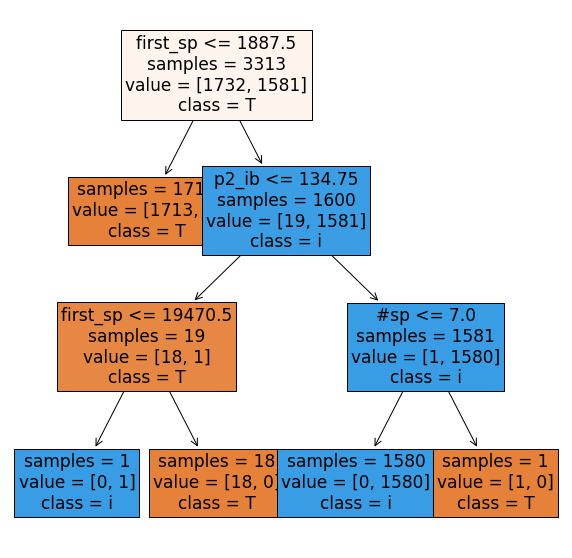

In [463]:
print(colored('Grafico el modelo', attrs=['bold']))
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [464]:
print(colored('Realizo la predicción del modelo con la porción de prueba', attrs=['bold']))
y_pred = model.predict(X_test)
y_pred

Realizo la predicción del modelo con la porción de prueba


array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [465]:
len(y_pred[y_pred == 0])

766

In [466]:
len(y_pred[y_pred == 1])

654

### Métricas y matriz de confusión

Matriz de confusión


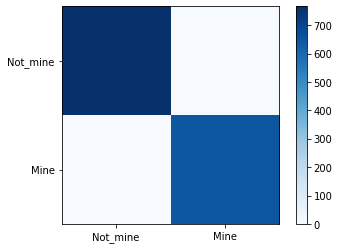

In [467]:
churm = matriz_confusion(y_test, y_pred, plt.cm.Blues)

In [468]:
pd.DataFrame(churm)

,0,1
0,766,3
1,0,651


In [469]:
metricas(y_test, y_pred, churm)

Exactitud:  0.997887323943662
Kappa:  0.9957467711403446
Predicciones de los registros mineros
Precisión:  0.9954128440366973
Recall:  1.0
Especificidad :  1.0
F1-score      :  0.9977011494252873
Predicciones de los registros no mineros
Precisión:  1.0
Recall:  0.9960988296488946
Especificidad :  0.9960988296488946
F1-score      :  0.9980456026058632


# Experimento 1

In [470]:
print(colored('Importo el conjunto de datos no puros', attrs=['bold']))
dataB = pd.read_csv('./data_no_identificada.csv')
dataB.columns

Importo el conjunto de datos no puros


Index(['index', 'Name', 'Netflows', 'First_Protocol', 'Second_Protocol',
       'Third_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'Type', 'Cryptocurrency'],
      dtype='object')

In [471]:
dataB.shape

(39554, 33)

In [472]:
print(colored('Valores faltantes del conjunto no puro', attrs=['bold']))
dataB.isnull().sum()

Valores faltantes del conjunto no puro


index                  0
Name                   0
Netflows               0
First_Protocol         0
Second_Protocol     6133
Third_Protocol     18674
p1_d                   0
p2_d                   0
p3_d                   0
duration               0
max_d                  0
min_d                  0
#packets               0
Avg_bps                0
Avg_pps                0
Avg_bpp                0
#Bytes                 0
#sp                    0
#dp                    0
first_sp               0
second_sp           7498
third_sp           10993
first_dp               0
second_dp           1708
third_dp            7103
p1_ip                  0
p2_ip                  0
p3_ip                  0
p1_ib                  0
p2_ib                  0
p3_ib                  0
Type                   0
Cryptocurrency         0
dtype: int64

In [473]:
print(colored('Elimino valores faltantes del conjunto de datos no puros, ya que estamos poniendo a prueba nuestro primer modelo, con datos tomados de ambientes no controlados, con la finalidad de observar como se comporta.', attrs=['bold']))

dataB = dataB.dropna()

Elimino valores faltantes del conjunto de datos no puros, ya que estamos poniendo a prueba nuestro primer modelo, con datos tomados de ambientes no controlados, con la finalidad de observar como se comporta.


In [474]:
dataC = dataB

In [475]:
dataB.shape

(19640, 33)

In [476]:
X = dataB[best_feature_sel]
y = dataB['Type'].replace({'mine':1,'not_mine':0})

In [477]:
y_pred = model.predict(X)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

Matriz de confusión


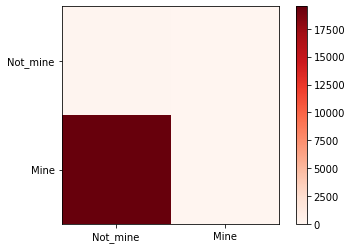

In [478]:
churm = matriz_confusion(y, y_pred, plt.cm.Reds)

In [479]:
pd.DataFrame(churm)

,0,1
0,129,0
1,19504,7


In [480]:
metricas(y, y_pred, churm)

Exactitud:  0.006924643584521385
Kappa:  4.714661605231818e-06
Predicciones de los registros mineros
Precisión:  1.0
Recall:  0.0003587719747834555
Especificidad :  0.0003587719747834555
F1-score      :  0.0007172866072343477
Predicciones de los registros no mineros
Precisión:  0.006570569958742933
Recall:  1.0
Especificidad :  1.0
F1-score      :  0.01305535876935533


# Experimento 2

In [481]:
print(colored('Caracteristicas del conjunto de datos puro', attrs=['bold']))
print(best_feature_sel)

Caracteristicas del conjunto de datos puro
['#dp', '#sp', 'Avg_bpp', 'first_dp', 'first_sp', 'min_d', 'p1_d', 'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_ib', 'second_dp', 'second_sp']


In [482]:
print(colored('Caracteristicas del conjunto de datos no puro', attrs=['bold']))
best_feature_noPure = ['#Bytes', '#dp', '#packets', '#sp', 'Avg_bpp', 'Avg_bps',
       'Avg_pps', 'duration', 'first_dp', 'p2_d', 'p2_ib', 'p3_d',
       'p3_ip', 'second_dp', 'second_sp', 'third_dp', 'third_sp']
print(best_feature_noPure)

Caracteristicas del conjunto de datos no puro
['#Bytes', '#dp', '#packets', '#sp', 'Avg_bpp', 'Avg_bps', 'Avg_pps', 'duration', 'first_dp', 'p2_d', 'p2_ib', 'p3_d', 'p3_ip', 'second_dp', 'second_sp', 'third_dp', 'third_sp']


In [483]:
print(colored('Combino las caracteristicas', attrs=['bold']))
bestFeature = np.concatenate([best_feature_sel,best_feature_noPure])
bestFeature = np.unique(bestFeature)
bestFeature

Combino las caracteristicas


array(['#Bytes', '#dp', '#packets', '#sp', 'Avg_bpp', 'Avg_bps',
       'Avg_pps', 'duration', 'first_dp', 'first_sp', 'min_d', 'p1_d',
       'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_d', 'p3_ib', 'p3_ip',
       'second_dp', 'second_sp', 'third_dp', 'third_sp'], dtype='<U9')

### Preprocesamiento

In [484]:
dataB = pd.read_csv('./data_no_identificada.csv').drop(['index','Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataB.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type', 'Cryptocurrency'],
      dtype='object')

### Imputar valores

In [485]:
punter = pd.concat([dataB['second_sp'],dataB['third_sp'],dataB['second_dp'],dataB['third_dp']], axis = 1)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
values = imputer.fit_transform(punter)

In [486]:
values = pd.DataFrame(values, columns = punter.columns)
dataB['second_sp'] = values['second_sp']
dataB['third_sp'] = values['third_sp']
dataB['second_dp'] = values['second_dp']
dataB['third_dp'] = values['third_dp']

### OneHotEncoder

In [487]:
data_categoric = dataB.select_dtypes(['object'])
one_hot =  OneHotEncoder()
one_hot.fit_transform(data_categoric)
dataDummy = pd.get_dummies(data_categoric)
dataB = dataB.drop(data_categoric.columns, axis = 1)
dataB = pd.concat([dataB,dataDummy],axis = 1)
dataB.head(1)

,Netflows,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,Avg_pps,...,p2_ib,p3_ib,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Does not have,Cryptocurrency_Unidentified
0,17,0.0,3.001,360.024,2790.015,569.693,0.0,95,160,0,...,500.0,700.0,0,0,0,1,1,0,0,1


In [488]:
print(colored('Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos', attrs=['bold']))
data_N_Mineros = dataB[dataB.Type_mine == 1]
data_N_Mineros = data_N_NoMineros = dataB.sample(n=dataA[dataA.Type_mine == 1].shape[0])

Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos


In [489]:
print(colored('Ambos conjuntos de datos, tienen los mismos registros benignos, se podria conciderar como una tecnica de sobremuestreo', attrs=['bold']))
nueva_dataB = pd.concat([data_N_Mineros, dataB[dataB.Type_mine == 0]], axis = 0)

Ambos conjuntos de datos, tienen los mismos registros benignos, se podria conciderar como una tecnica de sobremuestreo


In [490]:
print(colored('Ambos conjuntos de datos (puros y no puro), se podrian conciderar balanceados ', attrs=['bold']))

nueva_dataB.shape, dataA.shape

Ambos conjuntos de datos (puros y no puro), se podrian conciderar balanceados 


((4733, 34), (4733, 38))

In [491]:
print(colored('Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros', attrs=['bold']))


Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros


In [492]:
data_final = pd.concat([nueva_dataB, dataA], axis = 0)
data_final.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(9466, 39)

In [493]:
print(colored('Aleatoriedad', attrs=['bold']))
data_final = data_final.reset_index()
indices = list(data_final.index)
random.shuffle(indices)
data_final = data_final.reindex(indices)
data_final.head()

Aleatoriedad


,index,#Bytes,#dp,#packets,#sp,Avg_bpp,Avg_bps,Avg_pps,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,...,p2_d,p2_ib,p2_ip,p3_d,p3_ib,p3_ip,second_dp,second_sp,third_dp,third_sp
2380,2375,16111,23,192,25,83,853,1,NaN,NaN,...,73.7160,160.0,4.0,97.99050,216.00,5.00,80.0,80.0,1900.0,123.0
5549,816,5089530,29,5652,31,900,292928,40,0.0,0.0,...,0.0000,32.0,1.0,4.89500,64.00,2.00,80.0,80.0,1900.0,53.0
9006,4273,55701,2,422,2,131,1172,1,0.0,0.0,...,93.2015,3936.0,51.5,142.54075,8678.75,79.25,64790.0,64790.0,443.0,123.0
2880,10260,82,2,2,2,41,19878,60,NaN,NaN,...,0.0000,41.0,1.0,0.00000,45.00,1.00,53.0,53.0,5353.0,45560.0
9106,4373,4580605,31,5135,32,892,302669,42,0.0,0.0,...,1.4775,64.0,2.0,45.19975,64.00,2.00,80.0,80.0,1900.0,123.0


In [494]:
data_final.isnull().sum()

index                              0
#Bytes                             0
#dp                                0
#packets                           0
#sp                                0
Avg_bpp                            0
Avg_bps                            0
Avg_pps                            0
Cryptocurrency_Bitcash          4733
Cryptocurrency_Bitcoin          4733
Cryptocurrency_Does not have       0
Cryptocurrency_Etherium         4733
Cryptocurrency_Litecoin         4733
Cryptocurrency_Monero           4733
Cryptocurrency_Unidentified     4733
First_Protocol_ICMP                0
First_Protocol_ICMP6               0
First_Protocol_TCP                 0
First_Protocol_UDP                 0
Netflows                           0
Type_mine                          0
Type_not_mine                      0
duration                           0
first_dp                           0
first_sp                           0
max_d                              0
min_d                              0
p

### Modelo

In [512]:
X = data_final[bestFeature]
y = data_final['Type_mine']

In [513]:
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [514]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=False)

for key in scores:
    score = scores[key]
    print("%s: %0.2f (+/- %0.2f)" % (key, score.mean(), score.std() * 2))


fit_time: 0.21 (+/- 0.06)
score_time: 0.02 (+/- 0.00)
test_accuracy: 1.00 (+/- 0.00)
test_precision_weighted: 1.00 (+/- 0.00)
test_recall_weighted: 1.00 (+/- 0.00)
test_f1_weighted: 1.00 (+/- 0.00)


In [515]:
K_fold = KFold(n_splits = 10)

In [516]:
resultados_train = []
resultados_test = []
predicciones = []
scores = []
modelos = []


for result in K_fold.split(X):
    resultados_train.append(result[0])
    resultados_test.append(result[1])
    X_train = X.iloc[result[0]]
    X_test =  X.iloc[result[1]]
    y_train =  y.iloc[result[0]]
    y_test =  y.iloc[result[1]]
    model = model.fit(X_train,y_train)
    modelos.append(model)
    predic = model.predict(X_test)
    predicciones.append(predic)
    scores.append(model.score(X_test, y_test))

In [517]:
scores

[0.9947201689545935,
 0.9989440337909187,
 0.9989440337909187,
 0.9989440337909187,
 0.996832101372756,
 0.9957761351636748,
 0.9989429175475687,
 0.9978858350951374,
 0.9989429175475687,
 0.9978858350951374]

Matriz de confusión


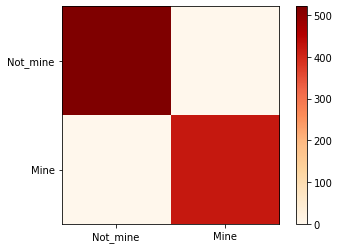

In [518]:
churm = matriz_confusion(y.iloc[resultados_test[9]], predicciones[9], plt.cm.OrRd)

In [519]:
pd.DataFrame(churm)

,0,1
0,521,0
1,2,423


In [520]:
metricas(y.iloc[resultados_test[9]], predicciones[9], churm)

Exactitud:  0.9978858350951374
Kappa:  0.9957258199332216
Predicciones de los registros mineros
Precisión:  1.0
Recall:  0.9952941176470588
Especificidad :  0.9952941176470588
F1-score      :  0.9976415094339623
Predicciones de los registros no mineros
Precisión:  0.9961759082217974
Recall:  1.0
Especificidad :  1.0
F1-score      :  0.9980842911877394


In [ ]:
modelos[2].predict

### Prueba final

In [521]:
X_p = dataC[bestFeature]
y_p = dataC['Type'].replace({'mine':1,'not_mine':0})

In [523]:
y_pred_proba = modelos[9].predict(X_p)

Matriz de confusión


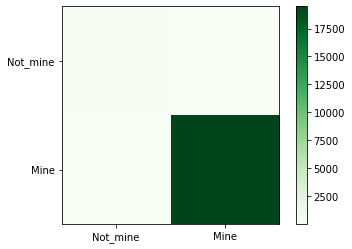

In [524]:
churm = matriz_confusion(y_p, y_pred_proba, plt.cm.Greens)

In [525]:
pd.DataFrame(churm)

,0,1
0,128,1
1,36,19475


In [532]:
dataC[dataC.Type=='mine'].shape

(19511, 33)

In [534]:
dataC[dataC.Type=='not_mine'].shape

(129, 33)

In [537]:
metricas(y_p, y_pred_proba, churm)

Exactitud:  0.9981160896130347
Kappa:  0.8727847445331123
Predicciones de los registros mineros
Precisión:  0.9999486547545697
Recall:  0.998154886986828
Especificidad :  0.998154886986828
F1-score      :  0.9990509657065175
Predicciones de los registros no mineros
Precisión:  0.7804878048780488
Recall:  0.9922480620155039
Especificidad :  0.9922480620155039
F1-score      :  0.8737201365187713


In [ ]:
y_pred_proba = model.predict_proba(X_test)

In [ ]:
lr_probs = y_pred_proba[:,1]

In [ ]:
ns_probs = [0 for _ in range(len(y_test))]

In [ ]:
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_auc

In [ ]:
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
lr_auc

In [ ]:
#Sumo los scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Treeb: ROC AUC=%.3f' % (lr_auc))

In [ ]:
ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)

In [ ]:
#Plot la roc curva para el modelo
plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Holdaunt 70% pero debo hacer una validadci{on cruzada en este conjunto de entrenamiento (Puros), de este cruz validation saldra un modelo, y lo testeo con el 30%, con este porcentaje, le saco las metricas